In [1]:
%%time
import fastai
from fastai.vision.all import *
from fastai.tabular.all import *
import os
from pathlib import Path

CPU times: user 1.49 s, sys: 1.08 s, total: 2.57 s
Wall time: 2.07 s


In [2]:
path = Path.cwd()/"whales_subset"

In [3]:
path

Path('/home/whales_subset')

In [4]:
train = pd.read_csv("train_subset.csv")

In [5]:
train.head()

,Unnamed: 0,Image,whaleID
0,16,w_1194.jpg,whale_08017
1,24,w_735.jpg,whale_89615
2,37,w_446.jpg,whale_68116
3,56,w_2883.jpg,whale_78280
4,89,w_3777.jpg,whale_78280


In [6]:
train.drop(["Unnamed: 0"], axis = 1, inplace = True)

In [7]:
whales = DataBlock(blocks = (ImageBlock, CategoryBlock),
                   splitter = RandomSplitter(),
                   get_x = ColReader(0, pref = path),
                   get_y = ColReader(1),
                   item_tfms = Resize(440),
                   batch_tfms = aug_transforms(size = 224, min_scale = 0.75))

In [8]:
dls = whales.dataloaders(train, device = "cuda")

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


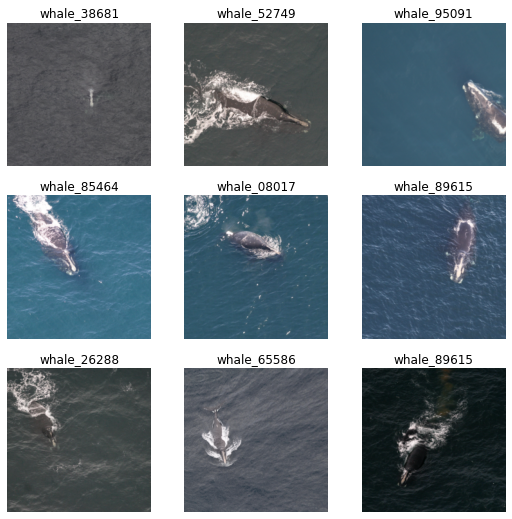

In [9]:
dls.show_batch(max_n = 9)

In [10]:
%%time
learn = cnn_learner(dls, resnet18, loss_func = CrossEntropyLossFlat(), metrics = error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth



CPU times: user 727 ms, sys: 218 ms, total: 945 ms
Wall time: 6.99 s


/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


CPU times: user 11.7 s, sys: 15 s, total: 26.7 s
Wall time: 3min 51s


/opt/conda/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0012022644514217973)

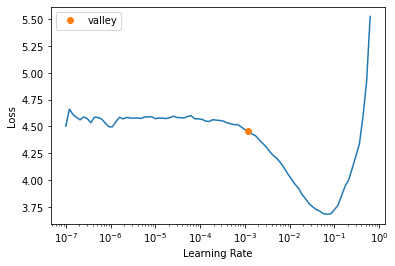

In [11]:
%%time

learn.lr_find()

In [12]:
learn.fit_one_cycle(5, 3e-2)

epoch,train_loss,valid_loss,error_rate,time
0,4.381666,8.499988,0.945455,00:27
1,4.277836,9.563621,0.954545,00:27
2,4.103703,7.676322,0.927273,00:27
3,3.995683,7.264070,0.918182,00:26
4,3.817597,4.266617,0.800000,00:27


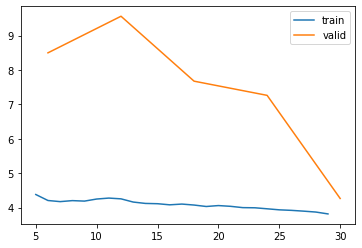

In [13]:
learn.recorder.plot_loss()

In [14]:
## training the model from scratch

In [9]:
def get_dls(size, bs):
    dblocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                        splitter = RandomSplitter(),
                        get_x = ColReader(0, pref = path),
                        get_y = ColReader(1), 
                        item_tfms = Resize(440),
                        batch_tfms = [*aug_transforms(size = size, min_scale = 0.75), 
                                      Normalize.from_stats(*imagenet_stats)])
    return dblocks.dataloaders(train, bs = bs, device = "cuda")

In [10]:
dls = get_dls(128, 128)

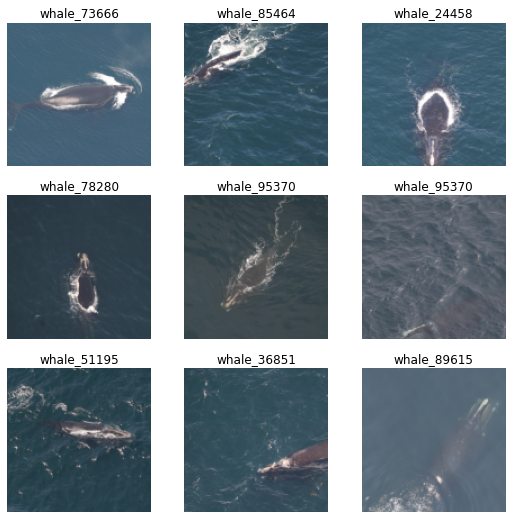

In [11]:
dls.show_batch(max_n = 9)

In [12]:
model = xresnet34()

learn = Learner(dls, model, loss_func = CrossEntropyLossFlat(), metrics = error_rate)

CPU times: user 16.8 s, sys: 40.6 s, total: 57.4 s
Wall time: 14min 9s


/opt/conda/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0020892962347716093)

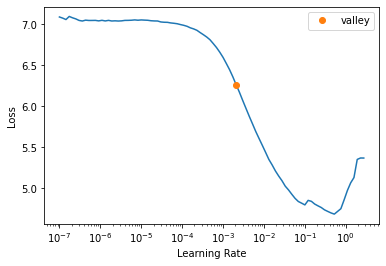

In [19]:
%%time

learn.lr_find()

In [13]:
%%time
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,6.879750,5.908766,0.954545,00:47
1,5.275589,6.225571,0.963636,00:44
2,4.448889,13.875913,0.936364,00:45
3,3.989388,10.162331,0.936364,00:45
4,3.683444,4.764836,0.927273,00:46


/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


CPU times: user 3.25 s, sys: 9.48 s, total: 12.7 s
Wall time: 3min 49s


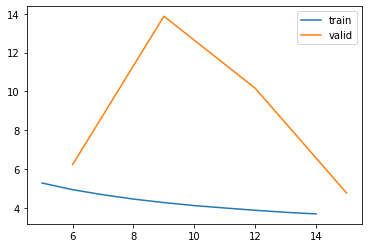

In [14]:
learn.recorder.plot_loss()

In [15]:
learn.dls = get_dls(224, 64)

In [16]:
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.636393,2.739907,0.818182,00:27


epoch,train_loss,valid_loss,error_rate,time
0,2.576608,2.529629,0.800000,00:28
1,2.560468,2.485124,0.718182,00:29
2,2.552066,2.456772,0.727273,00:33
3,2.517962,2.444279,0.736364,00:27
4,2.482582,2.438686,0.745455,00:27


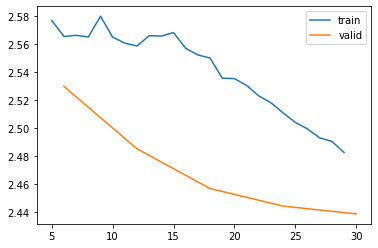

In [17]:
learn.recorder.plot_loss()

In [18]:
preds, targs = learn.tta()

In [19]:
error_rate(preds, targs).item()

0.800000011920929

In [20]:
accuracy(preds, targs).item()

0.20000000298023224

In [21]:
dls.vocab

['whale_08017', 'whale_24458', 'whale_26288', 'whale_28892', 'whale_34656', 'whale_36851', 'whale_38681', 'whale_48966', 'whale_51195', 'whale_52749', 'whale_65586', 'whale_68116', 'whale_73666', 'whale_78280', 'whale_79823', 'whale_85464', 'whale_89615', 'whale_90957', 'whale_95091', 'whale_95370']

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

CPU times: user 902 ms, sys: 13.6 ms, total: 916 ms
Wall time: 270 ms


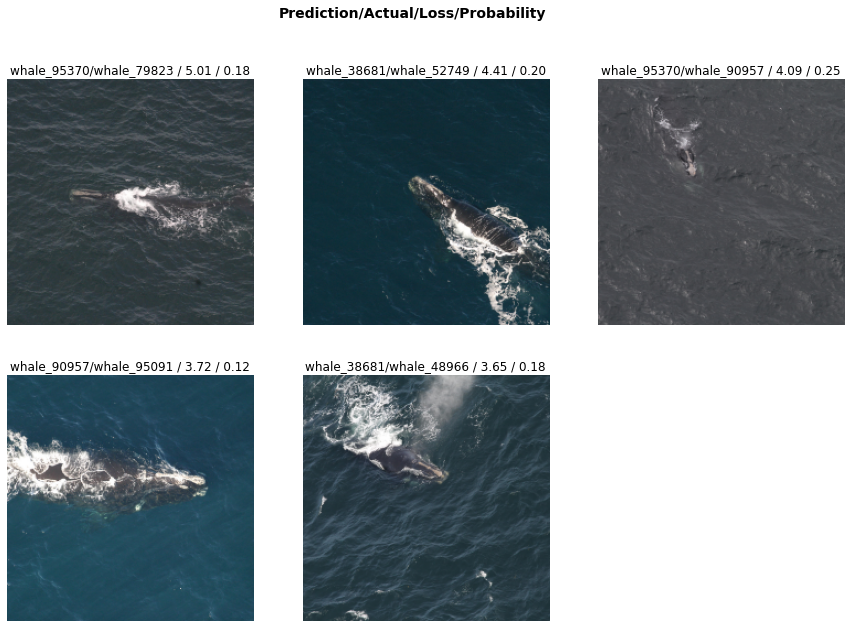

In [25]:
%%time
interp.plot_top_losses(5, nrows = 2, figsize = (15, 10))